In [1]:
!pip install torchaudio > .null.txt
!pip install PyDrive > .null.txt
!pip install soundfile > .null.txt

import torch
import torch.nn as nn
import torchaudio
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np

import progressbar
from multiprocessing import Pool


import os
import time
from os.path import exists, join, basename, splitext

In [2]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
! git clone https://github.com/facebookresearch/CPC_audio.git  #

Cloning into 'CPC_audio'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 84 (delta 13), reused 75 (delta 6), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [4]:
%cd /content/CPC_audio
!python setup.py develop > .null.text

/content/CPC_audio
In file included from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1832:0,
                 from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from cpc/eval/ABX/dtw.c:625:
/usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it with " \
  ^~~~~~~


In [5]:
# get the code
!git clone --recursive https://github.com/parlance/ctcdecode.git
%cd ctcdecode

!pip install -r requirements.txt

!python setup.py install > .null.txt

Cloning into 'ctcdecode'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 979 (delta 3), reused 1 (delta 0), pack-reused 966
Receiving objects: 100% (979/979), 740.44 KiB | 6.98 MiB/s, done.
Resolving deltas: 100% (467/467), done.
Submodule 'third_party/ThreadPool' (https://github.com/progschj/ThreadPool.git) registered for path 'third_party/ThreadPool'
Submodule 'third_party/kenlm' (https://github.com/kpu/kenlm.git) registered for path 'third_party/kenlm'
Cloning into '/content/CPC_audio/ctcdecode/third_party/ThreadPool'...
remote: Enumerating objects: 82, done.        
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82        
Cloning into '/content/CPC_audio/ctcdecode/third_party/kenlm'...
remote: Enumerating objects: 97, done.        
remote: Counting objects: 100% (97/97), done.        
remote: Compressing objects: 100% (80/80), done.        
remote: Total 13421 (delta

## Exercice 1 : Building the model

In this exercise, we will build and train a small CPC model using the repository CPC_audio.

The code below loads a context and an encoder newtorks.

In [2]:
%cd /content/CPC_audio
from cpc.model import CPCEncoder, CPCAR
from cpc.dataset import findAllSeqs, AudioBatchData, parseSeqLabels
from cpc.feature_loader import loadModel
from cpc.eval.common_voices_eval import SingleSequenceDataset, parseSeqLabels, findAllSeqs
from ctcdecode import  CTCBeamDecoder


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DIM_ENCODER=256
DIM_CONTEXT=256
KEEP_HIDDEN_VECTOR=False
N_LEVELS_CONTEXT=1
CONTEXT_RNN="LSTM"
N_PREDICTIONS=12
LEARNING_RATE=2e-4
N_NEGATIVE_SAMPLE =128

/content/CPC_audio


# Part 2 : Fine tuning

## Exercice 1 : Phone separability with aligned phonemes.

One option to evaluate the quality of the features trained with CPC can be to check if they can be used to recognize phonemes. 
To do so, we can fine-tune a pre-trained model using a limited amount of labelled speech data.
We are going to start with a simple evaluation setting where we have the phone labels for each timestep corresponding to a CPC feature.

We will work with a model already pre-trained on English data. As far as the fine-tuning dataset is concerned, we will use a 1h subset of [librispeech-100](http://www.openslr.org/12/). 

In [3]:
!mkdir checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt -P checkpoint_data > .null.txt
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json -P checkpoint_data > .null.txt
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_args.json -P checkpoint_data > .null.txt
#!ls checkpoint_data

--2020-07-06 15:51:23--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113599715 (108M) [application/octet-stream]
Saving to: ‘checkpoint_data/checkpoint_30.pt’

checkpoint_30.pt    100%[===================>] 108.34M  18.6MB/s    in 6.6s    

2020-07-06 15:51:30 (16.4 MB/s) - ‘checkpoint_data/checkpoint_30.pt’ saved [113599715/113599715]

--2020-07-06 15:51:31--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request 

### Build the phone classifier 

Design a class of linear classifiers, ```PhoneClassifier``` that will take as input a batch of sequences of CPC features and output a score vector for each phoneme

In [4]:
class PhoneClassifier(torch.nn.Module):

  def __init__(self,
               input_dim : int,
               n_phones : int):
    super(PhoneClassifier, self).__init__()
   # self.linear = torch.nn.Linear(input_dim, input_dim//2)
    self.linear1 = torch.nn.Linear(input_dim, n_phones)    

  def forward(self, x):
    #x = self.linear(x)
    #x = F.gelu(x)
    #x = F.dropout(x)
    x = self.linear1(x)    
    return x
    

### Pre-training and loading Model

Since the phonemes are not aligned, there is no simple direct way to get the classification acuracy of a model. Write and test the three functions ```train_one_epoch_ctc```, ```validation_step_ctc``` and ```run_ctc``` as before but without considering the average acuracy of the model. 

#### Trainin-validation functions

In [5]:
def train_one_epoch_ctc(cpc_model, 
                        phone_classifier, 
                        loss_criterion, 
                        data_loader, 
                        optimizer):
  
  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):

    x, x_len, y, y_len = full_data

    x_batch_len = x.shape[-1]
    x, y = x.to(device), y.to(device)

    bs=x.size(0)
    optimizer.zero_grad()
    context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
  
    scores = phone_classifier(context_out)
    scores = scores.permute(1,0,2)
    scores = F.log_softmax(scores,2)
    yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

    loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
  avg_loss/=n_items
  return avg_loss

def validation_step(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader):

  cpc_model.eval()
  phone_classifier.eval()
  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):

      x, x_len, y, y_len = full_data

      x_batch_len = x.shape[-1]
      x, y = x.to(device), y.to(device)

      bs=x.size(0)
      context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
    
      scores = phone_classifier(context_out)
      scores = scores.permute(1,0,2)
      scores = F.log_softmax(scores,2)
      yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

      loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
      avg_loss+=loss.item()*bs
      n_items+=bs

  avg_loss/=n_items
  cer = get_per(data_loader_val,cpc_model,character_classifier)

  return avg_loss, cer

def run_ctc(cpc_model, 
            phone_classifier, 
            loss_criterion, 
            data_loader_train, 
            data_loader_val, 
            optimizer,
            scheduler,
            n_epoch):
  
  #best_valid_loss = float('inf')
  best_cer = float('inf')
  train_loss = []
  valid_loss = []
  epoc_cer = []
  
  for epoch in range(n_epoch):

    # Print Learning Rate
    print(f"Running epoch {epoch + 1} / {n_epoch}")# LR: {scheduler.get_lr()}")

    loss_train = train_one_epoch_ctc(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer)
    print("-------------------")
    print(f"Training dataset :")
    print(f"Average loss : {loss_train:.4f}.")

    print("-------------------")
    print("Validation dataset")
    loss_val, cer = validation_step(cpc_model, phone_classifier, loss_criterion, data_loader_val)
    print(f"Average loss : {loss_val:.4f}")
    #print(f"Average CER : {cer:.4f}")
    print("-------------------")
    print()
    scheduler.step(loss_val)
    
    train_loss.append(loss_train)
    valid_loss.append(loss_val)
    epoc_cer.append(cer)

    if cer < best_cer:
        best_cer = cer
        torch.save(cpc_model.state_dict(), 'best_cpc-model.pth')
        torch.save(phone_classifier.state_dict(), 'best_phone_classifier-model.pth')
  print(f'Best CER is: {best_cer}')
  return train_loss, valid_loss, epoc_cer


### b- Evaluation: the Phone Error Rate (PER)

In order to compute the similarity between two sequences, we can use the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance). This distance estimates the minimum number of insertion, deletion and addition to move from one sequence to another. If we normalize this distance by the number of characters in the reference sequence we get the Phone Error Rate (PER).

This value can be interpreted as :
\\[  PER = \frac{S + D + I}{N} \\]

Where:


*   N is the number of characters in the reference
*   S is the number of substitutiion
*   I in the number of insertion
*   D in the number of deletion

For the best possible alignment of the two sequences.



In [6]:
def get_PER_sequence(ref_seq, target_seq):

  # re = g.split()
  # h = h.split()
  n = len(ref_seq)
  m = len(target_seq)

  D = np.zeros((n+1,m+1))
  for i in range(1,n+1):
    D[i,0] = D[i-1,0]+1
  for j in range(1,m+1):
    D[0,j] = D[0,j-1]+1
  
  ### TODO compute the alignment

  for i in range(1,n+1):
    for j in range(1,m+1):
      D[i,j] = min(
          D[i-1,j]+1,
          D[i-1,j-1]+1,
          D[i,j-1]+1,
          D[i-1,j-1]+ 0 if ref_seq[i-1]==target_seq[j-1] else float("inf")
      )
  return D[n,m]/len(ref_seq)
  

  #return PER

#### Evaluating the PER of your model on the test dataset

Evaluate the PER on the validation dataset. Please notice that you should usually use a separate dataset, called the dev dataset, to perform this operation. However for the sake of simplicity we will work with validation data in this exercise.

In [8]:
def cut_data(seq, sizeSeq):
    maxSeq = sizeSeq.max()
    return seq[:, :maxSeq]


def prepare_data(data):
    seq, sizeSeq, phone, sizePhone = data
    seq = seq.cuda()
    phone = phone.cuda()
    sizeSeq = sizeSeq.cuda().view(-1)
    sizePhone = sizePhone.cuda().view(-1)

    seq = cut_data(seq.permute(0, 2, 1), sizeSeq).permute(0, 2, 1)
    return seq, sizeSeq, phone, sizePhone


def get_per(test_dataloader,
            cpc_model,
            phone_classifier):

  downsampling_factor = 160
  cpc_model.eval()
  phone_classifier.eval()

  avgPER = 0
  nItems = 0 

  print("Starting the PER computation through beam search")
  bar = progressbar.ProgressBar(maxval=len(test_dataloader))
  bar.start()

  for index, data in enumerate(test_dataloader):

    bar.update(index)

    with torch.no_grad():
      
        seq, sizeSeq, phone, sizePhone = prepare_data(data)
        c_feature, _, _ = cpc_model(seq.to(device),phone.to(device))
        sizeSeq = sizeSeq / downsampling_factor
        predictions = torch.nn.functional.softmax(
        phone_classifier(c_feature), dim=2).cpu()
        phone = phone.cpu()
        sizeSeq = sizeSeq.cpu()
        sizePhone = sizePhone.cpu()

        bs = c_feature.size(0)
        batch_seq = seq.shape[-1]
                
        ALPHA = 0.1  # 
        BETA = 0  # not so important

        #seqlen = torch.tensor([int(predictions.shape[1]*sizeSeq[i]/batch_seq) for i in range(predictions.shape[0])]) # this is an approximation, should be good enough

        decoder = CTCBeamDecoder(labels= sorted_char, model_path=lm_model,
                                 alpha = ALPHA,
                                 beta = BETA,
                                 beam_width=20,
                                 cutoff_top_n=32,
                                 num_processes=4)
        
        output, scores, timesteps, out_seq_len = decoder.decode(predictions)
        
        output=output[torch.arange(bs),scores.argmax(1),:]
        out_seq_len= out_seq_len[torch.arange(bs),scores.argmax(1)]
        
        data_per = []

        for i in range(bs):
          data_per.append((phone[i][:sizePhone[i].item()],output[i][:out_seq_len[i].item()]))
        
        with Pool(bs) as p:
            poolData = p.starmap(get_PER_sequence, data_per)
        avgPER += sum([x for x in poolData])
        nItems += len(poolData)

  bar.finish()

  avgPER /= nItems

  print(f"Average CER {avgPER:.4f}")
  return avgPER


## Exercice 3 : Character error rate (CER) 

The Character Error Rate (CER) is an evaluation metric similar to the PER but with characters insterad of phonemes. Using the following data, run the functions you defined previously to estimate the CER of your model after fine-tuning.

##### Loading dataset

In [10]:
!unzip -q '/content/drive/My Drive/Speech Recognition/data.zip' -d /content/data
pt = '/content/data/data/'

replace /content/data/data/records/train/200702-193159_kin_60a_elicit_353.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [11]:
with open(pt + "charset.json", 'r', encoding='utf-8') as f:
  characters = eval(f.read())

In [12]:
char_dic = sorted(characters.items(), key=lambda x: x[1], reverse=False)
sorted_char = [b[0] for b in char_dic]

In [13]:
lm_model = '/content/drive/My Drive/Speech Recognition/kin.lm.arpa'   

In [14]:
# Load a dataset labelled with the letters of each sequence.
path_train_data_cer = pt + 'records/train'
path_val_data_cer = pt + 'records/val'
path_test_data_cer = pt + 'records/test'
path_letter_data_cer = pt + 'chars.txt' 
BATCH_SIZE=4

letters_labels, _ = parseSeqLabels(path_letter_data_cer)
data_train_cer, _ = findAllSeqs(path_train_data_cer, extension='.wav')
dataset_train_non_aligned = SingleSequenceDataset(path_train_data_cer, data_train_cer, letters_labels)
data_loader_train = torch.utils.data.DataLoader(dataset_train_non_aligned, batch_size=BATCH_SIZE,
                                                shuffle=True)
N_LETTERS = len(sorted_char) # Adding size for the blank label

data_val_cer, _ = findAllSeqs(path_val_data_cer, extension='.wav')
dataset_val_non_aligned = SingleSequenceDataset(path_val_data_cer, data_val_cer, letters_labels)
data_loader_val = torch.utils.data.DataLoader(dataset_val_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=True)

data_test_cer, _ = findAllSeqs(path_test_data_cer, extension='.wav')
dataset_test_non_aligned = SingleSequenceDataset(path_test_data_cer, data_test_cer, letters_labels)
data_loader_test = torch.utils.data.DataLoader(dataset_test_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=True)

# The data loader will generate a tuple of tensors data, labels for each batch
# data : size N x T1 x 1 : the audio sequence
# label : size N x T2 the sequence of letters corresponding to the audio data
# IMPORTANT NOTE: just like the PER the CER is computed with non-aligned phone data.

1it [00:00, 272.09it/s]

Saved cache file at /content/data/data/records/train/_seqs_cache.txt



1it [00:00, 226.17it/s]

Loaded 466 sequences in 1.76 seconds
maxSizeSeq : 289311
maxSizePhone : 180
minSizePhone : 75
Total size dataset 1.4055536458333333 hours
Saved cache file at /content/data/data/records/val/_seqs_cache.txt



1it [00:00, 234.53it/s]

Loaded 118 sequences in 0.95 seconds
maxSizeSeq : 238854
maxSizePhone : 148
minSizePhone : 84
Total size dataset 0.35288515625 hours
Saved cache file at /content/data/data/records/test/_seqs_cache.txt


Loaded 390 sequences in 1.74 seconds
maxSizeSeq : 244662
maxSizePhone : 171
minSizePhone : 59
Total size dataset 1.15069109375 hours


#### Loading pretrained cpc_model

In [15]:
checkpoint_path = 'checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
cpc_model = cpc_model.cuda()
character_classifier = PhoneClassifier(HIDDEN_CONTEXT_MODEL, N_LETTERS).to(device)

Loading checkpoint checkpoint_data/checkpoint_30.pt
Loading the state dict at checkpoint_data/checkpoint_30.pt


#### optimizers and hyperparameters definition

In [17]:
parameters = list(character_classifier.parameters()) + list(cpc_model.parameters())
LEARNING_RATE = 3e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)

scheduler = ReduceLROnPlateau(optimizer, factor=0.2, patience=0, verbose=True)

In [20]:
loss_ctc = torch.nn.CTCLoss()

##### Training the whole model and evaluation + 2FNN 

In [35]:
torch.manual_seed(0)

train_loss, valid_loss, epoc_cer = run_ctc(cpc_model,character_classifier,loss_ctc,data_loader_train,
                                           data_loader_val,optimizer,scheduler,n_epoch=56)

Running epoch 1 / 56
-------------------
Training dataset :
Average loss : 9.3121.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.8371
Average loss : 3.0769
-------------------

Running epoch 2 / 56
-------------------
Training dataset :
Average loss : 2.9843.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8220
Average loss : 2.9295
-------------------

Running epoch 3 / 56
-------------------
Training dataset :
Average loss : 2.9192.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8143
Average loss : 2.9099
-------------------

Running epoch 4 / 56
-------------------
Training dataset :
Average loss : 2.9083.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.8204
Average loss : 2.9070
-------------------

Running epoch 5 / 56
-------------------
Training dataset :
Average loss : 2.9047.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.8259
Average loss : 2.9045
-------------------

Running epoch 6 / 56
-------------------
Training dataset :
Average loss : 2.9037.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:20 Time:  0:00:20


Average CER 0.8151
Average loss : 2.9028
-------------------

Running epoch 7 / 56
-------------------
Training dataset :
Average loss : 2.9017.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8255
Average loss : 2.9009
-------------------

Running epoch 8 / 56
-------------------
Training dataset :
Average loss : 2.9013.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.8283
Average loss : 2.9012
-------------------

Epoch     8: reducing learning rate of group 0 to 9.0000e-05.
Running epoch 9 / 56
-------------------
Training dataset :
Average loss : 2.8989.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8215
Average loss : 2.8992
-------------------

Running epoch 10 / 56
-------------------
Training dataset :
Average loss : 2.8990.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:20 Time:  0:00:20


Average CER 0.8119
Average loss : 2.8987
-------------------

Running epoch 11 / 56
-------------------
Training dataset :
Average loss : 2.8988.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8187
Average loss : 2.8978
-------------------

Running epoch 12 / 56
-------------------
Training dataset :
Average loss : 2.8988.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.8273
Average loss : 2.8974
-------------------

Running epoch 13 / 56
-------------------
Training dataset :
Average loss : 2.8977.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8158
Average loss : 2.8990
-------------------

Epoch    13: reducing learning rate of group 0 to 2.7000e-05.
Running epoch 14 / 56
-------------------
Training dataset :
Average loss : 2.8966.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8207
Average loss : 2.8978
-------------------

Epoch    14: reducing learning rate of group 0 to 8.1000e-06.
Running epoch 15 / 56
-------------------
Training dataset :
Average loss : 2.8959.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:20 Time:  0:00:20


Average CER 0.8231
Average loss : 2.8980
-------------------

Epoch    15: reducing learning rate of group 0 to 2.4300e-06.
Running epoch 16 / 56
-------------------
Training dataset :
Average loss : 2.8964.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8271
Average loss : 2.8987
-------------------

Epoch    16: reducing learning rate of group 0 to 7.2900e-07.
Running epoch 17 / 56
-------------------
Training dataset :
Average loss : 2.8960.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.8256
Average loss : 2.8974
-------------------

Epoch    17: reducing learning rate of group 0 to 2.1870e-07.
Running epoch 18 / 56
-------------------
Training dataset :
Average loss : 2.8956.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.8225
Average loss : 2.8960
-------------------

Running epoch 19 / 56
-------------------
Training dataset :
Average loss : 2.8960.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8234
Average loss : 2.8978
-------------------

Epoch    19: reducing learning rate of group 0 to 6.5610e-08.
Running epoch 20 / 56
-------------------
Training dataset :
Average loss : 2.8958.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8235
Average loss : 2.8973
-------------------

Epoch    20: reducing learning rate of group 0 to 1.9683e-08.
Running epoch 21 / 56
-------------------
Training dataset :
Average loss : 2.8952.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8264
Average loss : 2.8987
-------------------

Epoch    21: reducing learning rate of group 0 to 5.9049e-09.
Running epoch 22 / 56
-------------------
Training dataset :
Average loss : 2.8964.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8219
Average loss : 2.8953
-------------------

Running epoch 23 / 56
-------------------
Training dataset :
Average loss : 2.8954.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8223
Average loss : 2.8970
-------------------

Running epoch 24 / 56
-------------------
Training dataset :
Average loss : 2.8959.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8236
Average loss : 2.8956
-------------------

Running epoch 25 / 56
-------------------
Training dataset :
Average loss : 2.8948.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8219
Average loss : 2.8969
-------------------

Running epoch 26 / 56
-------------------
Training dataset :
Average loss : 2.8955.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.8208
Average loss : 2.8975
-------------------

Running epoch 27 / 56
-------------------
Training dataset :
Average loss : 2.8960.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8271
Average loss : 2.8970
-------------------

Running epoch 28 / 56
-------------------
Training dataset :
Average loss : 2.8958.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8196
Average loss : 2.8966
-------------------

Running epoch 29 / 56
-------------------
Training dataset :
Average loss : 2.8952.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8228
Average loss : 2.8976
-------------------

Running epoch 30 / 56
-------------------
Training dataset :
Average loss : 2.8962.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8213
Average loss : 2.8968
-------------------

Running epoch 31 / 56
-------------------
Training dataset :
Average loss : 2.8960.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8238
Average loss : 2.8969
-------------------

Running epoch 32 / 56
-------------------
Training dataset :
Average loss : 2.8963.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8249
Average loss : 2.8967
-------------------

Running epoch 33 / 56
-------------------
Training dataset :
Average loss : 2.8953.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.8233
Average loss : 2.8978
-------------------

Running epoch 34 / 56
-------------------
Training dataset :
Average loss : 2.8958.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8238
Average loss : 2.8968
-------------------

Running epoch 35 / 56
-------------------
Training dataset :
Average loss : 2.8954.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8246
Average loss : 2.8966
-------------------

Running epoch 36 / 56
-------------------
Training dataset :
Average loss : 2.8965.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.8241
Average loss : 2.8987
-------------------

Running epoch 37 / 56
-------------------
Training dataset :
Average loss : 2.8960.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8216
Average loss : 2.8973
-------------------

Running epoch 38 / 56
-------------------
Training dataset :
Average loss : 2.8962.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8227
Average loss : 2.8955
-------------------

Running epoch 39 / 56
-------------------
Training dataset :
Average loss : 2.8963.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8243
Average loss : 2.8961
-------------------

Running epoch 40 / 56
-------------------
Training dataset :
Average loss : 2.8952.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8227
Average loss : 2.8969
-------------------

Running epoch 41 / 56
-------------------
Training dataset :
Average loss : 2.8962.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8238
Average loss : 2.8980
-------------------

Running epoch 42 / 56
-------------------
Training dataset :
Average loss : 2.8966.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8256
Average loss : 2.8973
-------------------

Running epoch 43 / 56
-------------------
Training dataset :
Average loss : 2.8956.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8219
Average loss : 2.8972
-------------------

Running epoch 44 / 56
-------------------
Training dataset :
Average loss : 2.8957.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8221
Average loss : 2.8983
-------------------

Running epoch 45 / 56
-------------------
Training dataset :
Average loss : 2.8954.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8278
Average loss : 2.8976
-------------------

Running epoch 46 / 56
-------------------
Training dataset :
Average loss : 2.8970.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8231
Average loss : 2.8973
-------------------

Running epoch 47 / 56
-------------------
Training dataset :
Average loss : 2.8962.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8195
Average loss : 2.8968
-------------------

Running epoch 48 / 56
-------------------
Training dataset :
Average loss : 2.8963.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8226
Average loss : 2.8968
-------------------

Running epoch 49 / 56
-------------------
Training dataset :
Average loss : 2.8961.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8185
Average loss : 2.8976
-------------------

Running epoch 50 / 56
-------------------
Training dataset :
Average loss : 2.8961.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8237
Average loss : 2.8970
-------------------

Running epoch 51 / 56
-------------------
Training dataset :
Average loss : 2.8956.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8197
Average loss : 2.8972
-------------------

Running epoch 52 / 56
-------------------
Training dataset :
Average loss : 2.8954.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.8233
Average loss : 2.8962
-------------------

Running epoch 53 / 56
-------------------
Training dataset :
Average loss : 2.8961.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8237
Average loss : 2.8981
-------------------

Running epoch 54 / 56
-------------------
Training dataset :
Average loss : 2.8949.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8238
Average loss : 2.8980
-------------------

Running epoch 55 / 56
-------------------
Training dataset :
Average loss : 2.8952.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


Average CER 0.8209
Average loss : 2.8973
-------------------

Running epoch 56 / 56
-------------------
Training dataset :
Average loss : 2.8961.
-------------------
Validation dataset


N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (15 of 15) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Average CER 0.8269
Average loss : 2.8973
-------------------

Best CER is: 0.8118522110640227


### Unfreezing few layers and One FFN

In [18]:
for p in cpc_model.gEncoder.conv0.parameters():
  p.requires_grad = False
for p in cpc_model.gEncoder.conv1.parameters():
  p.requires_grad = False
for p in cpc_model.gEncoder.conv4.parameters():
  p.requires_grad = False

In [21]:
torch.manual_seed(0)

train_loss, valid_loss, epoc_cer = run_ctc(cpc_model,character_classifier,loss_ctc,data_loader_train,
                                           data_loader_val,optimizer,scheduler,n_epoch=56)

Running epoch 1 / 56


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


-------------------
Training dataset :
Average loss : 5.5532.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9993
Average loss : 2.9446
-------------------

Running epoch 2 / 56
-------------------
Training dataset :
Average loss : 2.9196.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9937
Average loss : 2.9048
-------------------

Running epoch 3 / 56
-------------------
Training dataset :
Average loss : 2.9013.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


Average CER 0.9937
Average loss : 2.9004
-------------------

Running epoch 4 / 56
-------------------
Training dataset :
Average loss : 2.8950.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


Average CER 0.9937
Average loss : 2.8958
-------------------

Running epoch 5 / 56
-------------------
Training dataset :
Average loss : 2.8904.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


Average CER 0.9937
Average loss : 2.8864
-------------------

Running epoch 6 / 56
-------------------
Training dataset :
Average loss : 2.8773.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


Average CER 0.9937
Average loss : 2.8636
-------------------

Running epoch 7 / 56
-------------------
Training dataset :
Average loss : 2.8427.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9918
Average loss : 2.8173
-------------------

Running epoch 8 / 56
-------------------
Training dataset :
Average loss : 2.7399.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


Average CER 0.9798
Average loss : 2.6723
-------------------

Running epoch 9 / 56
-------------------
Training dataset :
Average loss : 2.5939.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


Average CER 0.9725
Average loss : 2.5080
-------------------

Running epoch 10 / 56
-------------------
Training dataset :
Average loss : 2.4244.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


Average CER 0.9804
Average loss : 2.3588
-------------------

Running epoch 11 / 56
-------------------
Training dataset :
Average loss : 2.2611.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


Average CER 0.9659
Average loss : 2.2028
-------------------

Running epoch 12 / 56
-------------------
Training dataset :
Average loss : 2.1118.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:16 Time:  0:00:16


Average CER 0.8946
Average loss : 2.0906
-------------------

Running epoch 13 / 56
-------------------
Training dataset :
Average loss : 1.9548.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:20 Time:  0:00:20


Average CER 0.7784
Average loss : 1.9161
-------------------

Running epoch 14 / 56
-------------------
Training dataset :
Average loss : 1.8145.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:21 Time:  0:00:21


Average CER 0.7100
Average loss : 1.7987
-------------------

Running epoch 15 / 56
-------------------
Training dataset :
Average loss : 1.6953.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


Average CER 0.6269
Average loss : 1.6671
-------------------

Running epoch 16 / 56
-------------------
Training dataset :
Average loss : 1.5738.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


Average CER 0.5779
Average loss : 1.5869
-------------------

Running epoch 17 / 56
-------------------
Training dataset :
Average loss : 1.4642.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:27 Time:  0:00:27


Average CER 0.5211
Average loss : 1.5479
-------------------

Running epoch 18 / 56
-------------------
Training dataset :
Average loss : 1.3823.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:28 Time:  0:00:28


Average CER 0.4731
Average loss : 1.4370
-------------------

Running epoch 19 / 56
-------------------
Training dataset :
Average loss : 1.3042.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:29 Time:  0:00:29


Average CER 0.4624
Average loss : 1.4478
-------------------

Epoch    19: reducing learning rate of group 0 to 6.0000e-05.
Running epoch 20 / 56
-------------------
Training dataset :
Average loss : 1.1861.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:29 Time:  0:00:29


Average CER 0.4211
Average loss : 1.3130
-------------------

Running epoch 21 / 56
-------------------
Training dataset :
Average loss : 1.1431.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:29 Time:  0:00:29


Average CER 0.4165
Average loss : 1.3080
-------------------

Running epoch 22 / 56
-------------------
Training dataset :
Average loss : 1.1186.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:29 Time:  0:00:29


Average CER 0.4243
Average loss : 1.2918
-------------------

Running epoch 23 / 56
-------------------
Training dataset :
Average loss : 1.0954.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:30 Time:  0:00:30


Average CER 0.4065
Average loss : 1.2816
-------------------

Running epoch 24 / 56
-------------------
Training dataset :
Average loss : 1.0748.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:30 Time:  0:00:30


Average CER 0.3965
Average loss : 1.2734
-------------------

Running epoch 25 / 56
-------------------
Training dataset :
Average loss : 1.0533.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:30 Time:  0:00:30


Average CER 0.3936
Average loss : 1.2720
-------------------

Running epoch 26 / 56
-------------------
Training dataset :
Average loss : 1.0350.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3870
Average loss : 1.2639
-------------------

Running epoch 27 / 56
-------------------
Training dataset :
Average loss : 1.0172.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:30 Time:  0:00:30


Average CER 0.3933
Average loss : 1.2555
-------------------

Running epoch 28 / 56
-------------------
Training dataset :
Average loss : 0.9970.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:30 Time:  0:00:30


Average CER 0.3910
Average loss : 1.2526
-------------------

Running epoch 29 / 56
-------------------
Training dataset :
Average loss : 0.9825.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3778
Average loss : 1.2553
-------------------

Epoch    29: reducing learning rate of group 0 to 1.2000e-05.
Running epoch 30 / 56
-------------------
Training dataset :
Average loss : 0.9496.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3855
Average loss : 1.2407
-------------------

Running epoch 31 / 56
-------------------
Training dataset :
Average loss : 0.9399.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3807
Average loss : 1.2404
-------------------

Running epoch 32 / 56
-------------------
Training dataset :
Average loss : 0.9345.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:30 Time:  0:00:30


Average CER 0.3804
Average loss : 1.2378
-------------------

Running epoch 33 / 56
-------------------
Training dataset :
Average loss : 0.9300.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:30 Time:  0:00:30


Average CER 0.3820
Average loss : 1.2381
-------------------

Epoch    33: reducing learning rate of group 0 to 2.4000e-06.
Running epoch 34 / 56
-------------------
Training dataset :
Average loss : 0.9233.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:30 Time:  0:00:30


Average CER 0.3801
Average loss : 1.2379
-------------------

Epoch    34: reducing learning rate of group 0 to 4.8000e-07.
Running epoch 35 / 56
-------------------
Training dataset :
Average loss : 0.9216.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:30 Time:  0:00:30


Average CER 0.3799
Average loss : 1.2379
-------------------

Epoch    35: reducing learning rate of group 0 to 9.6000e-08.
Running epoch 36 / 56
-------------------
Training dataset :
Average loss : 0.9211.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:32 Time:  0:00:32


Average CER 0.3792
Average loss : 1.2380
-------------------

Epoch    36: reducing learning rate of group 0 to 1.9200e-08.
Running epoch 37 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3788
Average loss : 1.2380
-------------------

Epoch    37: reducing learning rate of group 0 to 3.8400e-09.
Running epoch 38 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3788
Average loss : 1.2380
-------------------

Running epoch 39 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:32 Time:  0:00:32


Average CER 0.3789
Average loss : 1.2380
-------------------

Running epoch 40 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3790
Average loss : 1.2380
-------------------

Running epoch 41 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3790
Average loss : 1.2380
-------------------

Running epoch 42 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3790
Average loss : 1.2380
-------------------

Running epoch 43 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3791
Average loss : 1.2380
-------------------

Running epoch 44 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3794
Average loss : 1.2380
-------------------

Running epoch 45 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3793
Average loss : 1.2380
-------------------

Running epoch 46 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3793
Average loss : 1.2380
-------------------

Running epoch 47 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3792
Average loss : 1.2380
-------------------

Running epoch 48 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3792
Average loss : 1.2380
-------------------

Running epoch 49 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3792
Average loss : 1.2380
-------------------

Running epoch 50 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3792
Average loss : 1.2380
-------------------

Running epoch 51 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3795
Average loss : 1.2380
-------------------

Running epoch 52 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3799
Average loss : 1.2380
-------------------

Running epoch 53 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3799
Average loss : 1.2380
-------------------

Running epoch 54 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3802
Average loss : 1.2380
-------------------

Running epoch 55 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3803
Average loss : 1.2380
-------------------

Running epoch 56 / 56
-------------------
Training dataset :
Average loss : 0.9210.
-------------------
Validation dataset


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:30 Time:  0:00:30


Average CER 0.3804
Average loss : 1.2380
-------------------

Best CER is: 0.3778215157223652


In [22]:
%cd /content/CPC_audio

cpc_model.load_state_dict(torch.load('best_cpc-model.pth'))
character_classifier.load_state_dict(torch.load('best_phone_classifier-model.pth'))

test_loss, cer = validation_step(cpc_model, character_classifier, loss_ctc, data_loader_test)

print(f'Test Loss: {test_loss:.3f} | Test CER: {cer*100:.2f}%')

/content/CPC_audio


N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (30 of 30) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


Average CER 0.3778
Test Loss: 1.221 | Test CER: 37.78%


#####Testing and evaluating the performance

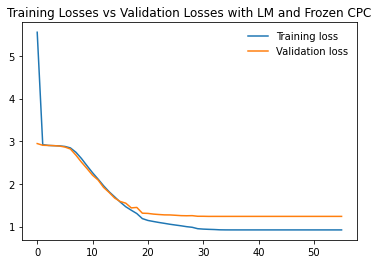

In [23]:
import numpy as np
import matplotlib.pyplot as plt


train_losses = np.array(train_loss)
valid_losses = np.array(valid_loss)
CER = np.array(epoc_cer)

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title("Training Losses vs Validation Losses with LM and Frozen CPC")
plt.show()

Text(0.5, 1.0, 'CER')

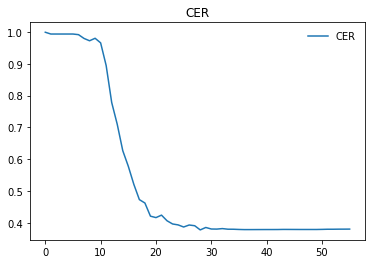

In [24]:
plt.plot(CER, label='CER')
plt.legend(frameon=False)
plt.title("CER")